In [1]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
import xarray as xr
from glob import glob
import sys, os
import cartopy
cartopy.config['pre_existing_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['repo_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
pr1=ccrs.PlateCarree()

sys.path.insert(0, os.path.abspath(os.path.join(".")))
from virtualargofleet import Velocity, VirtualFleet, FloatConfiguration, VelocityField

In [2]:
ds = xr.open_dataset('/home/ref-cmems-public/tac/multiobs/MULTIOBS_GLO_PHY_REP_015-002/ARMOR3D/data/2008/dataset-armor-3d-rep-weekly_20080102T1200Z_P20190301T0000Z.nc')
ds = ds.squeeze()

In [6]:
mask = ((~ds['ugo'].isnull()).astype(int) * ds['ugo'].depth).max('depth') - 50

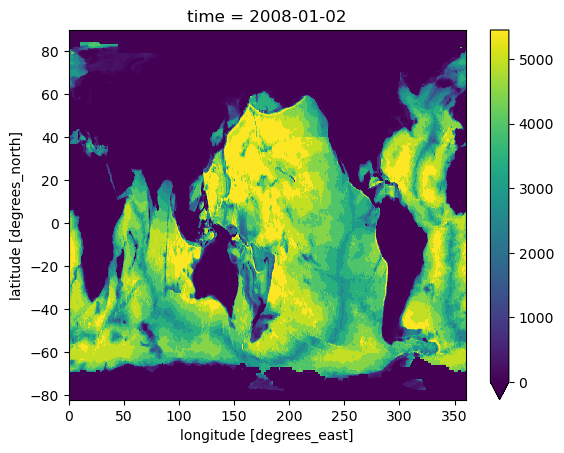

In [8]:
mask.plot(vmin=0)

In [9]:
files = '/home/ref-cmems-public/tac/multiobs/MULTIOBS_GLO_PHY_REP_015-002/ARMOR3D/data/2008/*.nc'

variables = {'U': 'ugo', 'V': 'vgo'}

dimensions = {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}

fieldset = FieldSet.from_netcdf(files, variables, dimensions, allow_time_extrapolation=True)

fieldset.add_field(Field('bathy',mask.values,lon=fieldset.U.lon,lat=fieldset.U.lat,interp_method='nearest'))

In [10]:
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1.)

604800.0

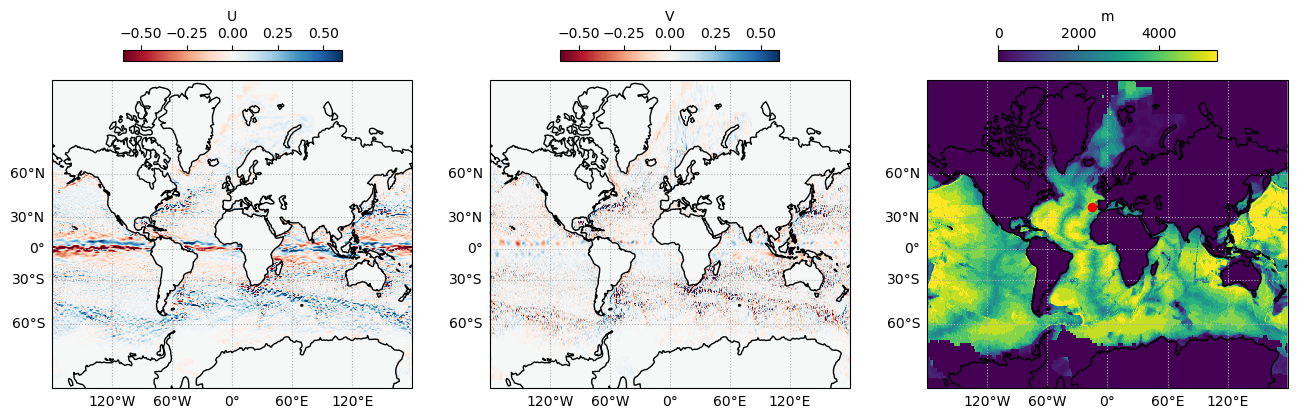

In [11]:
fig=plt.figure(figsize=(16,5))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 3, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:,:],shading='auto',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='U')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 2, projection=pr2)
a=ax1.pcolormesh(fieldset.V.grid.lon,fieldset.V.grid.lat,fieldset.V.data[0,0,:,:],shading='auto',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='V')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 3, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:,:],shading='auto',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ax1.plot(-15.911400303628652, 38.73887577854611,'ro',transform=pr1)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
plt.colorbar(a,location='top',shrink=0.6,label='m')

In [12]:
# Set min/max depth for float conf, this is to make sure Parcels doesn't struggle 
min_depth = 2.5 #np.ceil(ds['depth_rho'].max(['sig_rho']).min().values)
max_depth = int(fieldset.gridset.grids[0].depth.max() / 100)*100
print(min_depth,max_depth)
fieldset.add_constant("vf_surface",min_depth)
fieldset.add_constant("vf_bottom", max_depth)

2.5 5500


In [13]:
gsize = 15
bbox=[344,350,37.5,45]
lon = np.linspace(bbox[0],bbox[1], num=gsize)
lat = np.linspace(bbox[2],bbox[3], num=gsize)
LLO,LLA=np.meshgrid(lon,lat)
lon = LLO.flatten()
lat = LLA.flatten()
nfloats = len(lon)
tim = np.array(['2008-03-14T12:00:00.00' for i in range(nfloats)],dtype='datetime64')
depth = np.array([min_depth for i in range(nfloats)])
# Define the deployment plan as a dictionary:
my_plan = {'lat': lat, 
           'lon': lon, 
           'time': tim, 
           'depth':depth}

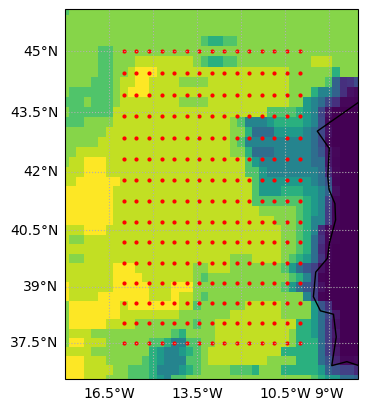

In [14]:
fig=plt.figure()
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 1, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1.plot(my_plan['lon'],my_plan['lat'],'r.',markersize=4,transform=pr1)
ax1.set_extent([bbox[0]-2,bbox[1]+2,bbox[2]-1,bbox[3]+1])

In [15]:
cfg = FloatConfiguration('default')
cfg.update('cycle_duration',24*10)
cfg.update('profile_depth',2000)
cfg.update('parking_depth',1000)
cfg

<FloatConfiguration><default>
- cycle_duration (Maximum length of float complete cycle): 240.0 [hours]
- life_expectancy (Maximum number of completed cycle): 200 [cycle]
- parking_depth (Drifting depth): 1000.0 [m]
- profile_depth (Maximum profile depth): 2000.0 [m]
- vertical_speed (Vertical profiling speed): 0.09 [m/s]

In [16]:
VFleet = VirtualFleet(plan=my_plan, fieldset=fieldset, mission=cfg, verbose_events=False)
VFleet

<VirtualFleet>
- 225 floats in the deployment plan
- No simulation performed

In [ ]:
VFleet.simulate(
            duration=timedelta(days=300),
            step=timedelta(minutes=5),
            record=timedelta(minutes=60),
            output_folder="/home1/scratch/kbalem/",
        )

In [18]:
dout=xr.open_zarr('/home1/scratch/kbalem/qyjoitkf.zarr')
dout.load()

<xarray.Dataset> Size: 4MB
Dimensions:       (trajectory: 225, obs: 406)
Coordinates:
  * obs           (obs) int32 2kB 0 1 2 3 4 5 6 ... 399 400 401 402 403 404 405
  * trajectory    (trajectory) int64 2kB 225 226 227 228 229 ... 446 447 448 449
Data variables:
    cycle_age     (trajectory, obs) float32 365kB 300.0 3.9e+03 ... 5.943e+05
    cycle_number  (trajectory, obs) float64 731kB 1.0 1.0 1.0 ... 2.0 2.0 2.0
    cycle_phase   (trajectory, obs) float64 731kB 0.0 0.0 0.0 ... 1.0 1.0 1.0
    in_water      (trajectory, obs) float32 365kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    lat           (trajectory, obs) float32 365kB 37.5 37.5 37.5 ... 45.17 45.17
    lon           (trajectory, obs) float32 365kB 344.0 344.0 ... 350.7 350.7
    time          (trajectory, obs) datetime64[ns] 731kB 2008-03-14T12:00:00 ...
    z             (trajectory, obs) float32 365kB 2.5 326.5 ... 1e+03 1e+03
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ArgoParticleArgoFloatKernelAdvectionRK4KeepInWate...
    parcels_mesh:           spherical
    parcels_version:        3.0.0

  6%|▌         | 1458300.0/25920000.0 [34:40<10:50:14, 626.99it/s]

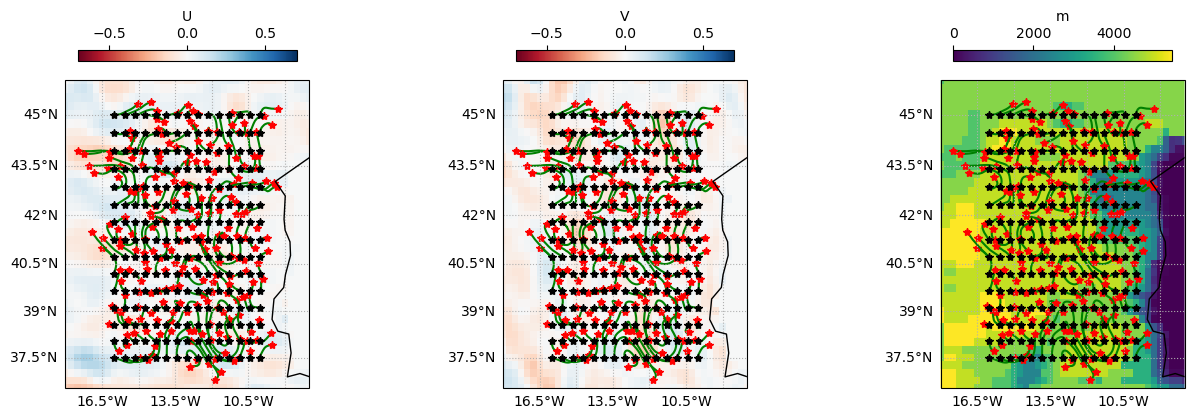

In [20]:
fig=plt.figure(figsize=(16,5))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 3, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.7,vmax=0.7,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'k*',transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'g',transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',transform=pr1)
plt.colorbar(a,location='top',shrink=0.6,label='U')
ax1.set_extent([bbox[0]-2,bbox[1]+2,bbox[2]-1,bbox[3]+1])

ax1 = fig.add_subplot(1, 3, 2, projection=pr2)
a=ax1.pcolormesh(fieldset.V.grid.lon,fieldset.V.grid.lat,fieldset.V.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.7,vmax=0.7,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'k*',transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'g',transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',transform=pr1)
plt.colorbar(a,location='top',shrink=0.6,label='V')    
ax1.set_extent([bbox[0]-2,bbox[1]+2,bbox[2]-1,bbox[3]+1])

ax1 = fig.add_subplot(1, 3, 3, projection=pr2)
a=ax1.pcolormesh(fieldset.bathy.grid.lon,fieldset.bathy.grid.lat,fieldset.bathy.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'k*',transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'g',transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',transform=pr1)
plt.colorbar(a,location='top',shrink=0.6,label='m')
ax1.set_extent([bbox[0]-2,bbox[1]+2,bbox[2]-1,bbox[3]+1])

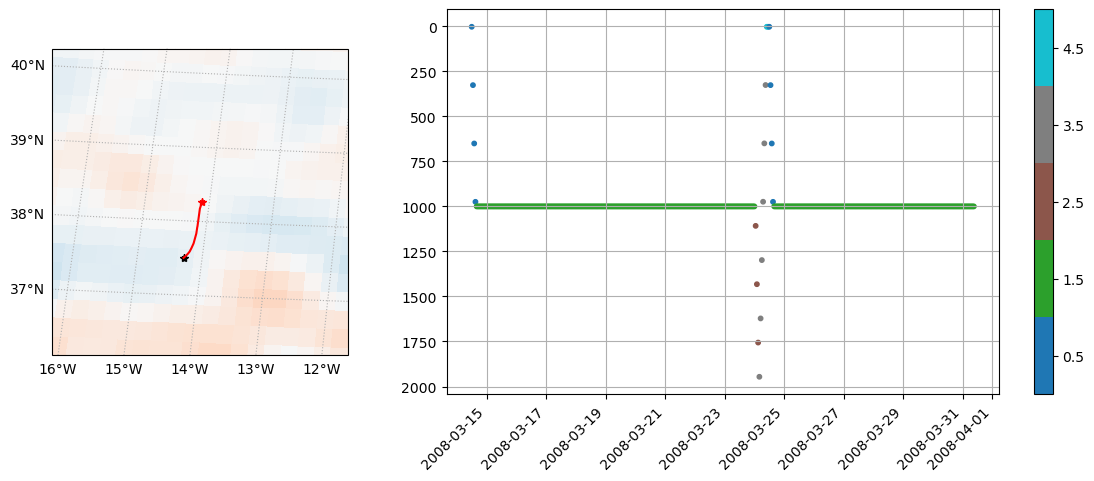

In [21]:
tr=4

fig=plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1,2,width_ratios=[.6,1.4])
pr1=ccrs.PlateCarree()
pr2=ccrs.LambertAzimuthalEqualArea()
ax1 = fig.add_subplot(gs[0], projection=pr2)
ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.7,vmax=0.7,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False

ax1.plot(dout['lon'].isel(trajectory=tr,obs=0),dout['lat'].isel(trajectory=tr,obs=0),'k*',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr),dout['lat'].isel(trajectory=tr),'r',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr,obs=-1),dout['lat'].isel(trajectory=tr,obs=-1),'r*',transform=pr1)
extent=[dout['lon'].isel(trajectory=tr,obs=-1).min().values -2,
        dout['lon'].isel(trajectory=tr,obs=-1).max().values +2,
        dout['lat'].isel(trajectory=tr,obs=-1).min().values -2,
        dout['lat'].isel(trajectory=tr,obs=-1).max().values +2]
ax1.set_extent(extent)

ax = fig.add_subplot(gs[1])
a=ax.scatter(dout['time'].isel(trajectory=tr),dout['z'].isel(trajectory=tr),s=10,c=dout['cycle_phase'].isel(trajectory=tr),cmap=plt.get_cmap('tab10',5),vmin=0,vmax=5)
ax.invert_yaxis()
_=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(':')
#ax.set_xlim([np.datetime64('2011-01-15'),np.datetime64('2011-01-16')])
plt.colorbar(a,ticks=[0.5,1.5,2.5,3.5,4.5])